In [1]:
import numpy as np
import h5py

from matplotlib.pylab import *
import numpy.linalg as la

import os
from tqdm.notebook import tqdm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)
plt.jet()

path = './data/'

<Figure size 1080x360 with 0 Axes>

### Feature Functions

In [2]:
def NumberConnections(Max,a,b): #Compute the ID, number of connections, and the connections
    pbar = tqdm(total = Max, desc="Computing Connections")
    ID=np.zeros(Max)
    Nc=np.zeros(Max)
    Connections=[]
    for n in range(Max):
        kx=b[(a==n)]
        ky=a[(b==n)]
        ID[n]=n
        Nc[n]=len(kx)+len(ky)
        Connections.append(np.concatenate([kx,ky],axis=0))
        pbar.update(1)
    pbar.close()
    return ID.astype(int),Nc.astype(int),np.array(Connections)

def DP(x1,y1,z1,x2,y2,z2):  #Compute the distance between two points
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

def Eigen(A):  # Return the eigenvalues of a Matrix
    w,v = la.eig(A)
    w[(w<0)]=0.0001   # To fix eigenvalues -10**-26
    return w

def Volume(a,b,c): # Compute the volume using the values, a,b,c
    v = a*b*c
    if v<=0:
        v=0.0001 # To fix densisty inf
    return v

def Features(Max,ID,x,y,z,nc,con): #Return the values of average distance and a,b,c values
    #------------ Nodes
    ad = np.zeros(Max)
    a = np.zeros(Max)
    b = np.zeros(Max)
    c = np.zeros(Max)
    vol = np.zeros(Max)
    den = np.zeros(Max)+np.exp(60)
    IDnn = ID[nc!=0]
    pbar = tqdm(total=len(IDnn), desc="Computing Features")
    for n in IDnn:
        Ixx = 0
        Iyy = 0
        Izz = 0
        Ixy = 0
        Iyz = 0
        Ixz = 0
        dist_temp = 0
        for i in con[n]:
            dist_temp = dist_temp+DP(x[n],y[n],z[n],x[i],y[i],z[i])
            Ixx = Ixx+(y[i]-y[n])**2+(z[i]-z[n])**2
            Iyy = Iyy+(z[i]-z[n])**2+(x[i]-x[n])**2
            Izz = Izz+(x[i]-x[n])**2+(y[i]-y[n])**2
            Ixy = Ixy-(x[i]-x[n])*(y[i]-y[n])
            Iyz = Iyz-(y[i]-y[n])*(z[i]-z[n])
            Ixz = Ixz-(x[i]-x[n])*(z[i]-z[n])
        pbar.update(1)
        
        ad[n] = dist_temp/nc[n]
        A=np.array([[Ixx,Ixy,Ixz],[Ixy,Iyy,Iyz],[Ixz,Iyz,Izz]])
        eig = Eigen(A)
        eig = np.sort(eig)[::-1]# Major -> Minor
        a[n] = np.sqrt(eig[0]).real #.real
        b[n] = np.sqrt(eig[1]).real
        c[n] = np.sqrt(eig[2]).real
        vol[n] = Volume(a[n],b[n],c[n])
        den[n] = 1/vol[n]
    pbar.close()
    return ad,vol,den

def neigh_features(Max,ID,nc,ncn,ad,den,con): #Compute all properties for first neighbors (Gradient)
    nc_n = np.zeros(Max)
    ad_n = np.zeros(Max)
    a_n = np.zeros(Max)
    b_n = np.zeros(Max)
    c_n = np.zeros(Max)
    den_n = np.zeros(Max)
    IDnn = ID[(nc!=0)]
    kk=0
    pbar = tqdm(total=len(IDnn), desc="Computing Delta Features")
    for i in IDnn:
        nc_temp = 0.0
        ad_temp = 0.0
        den_temp = 0.0
        for j in con[i]:
            nc_temp = nc_temp+ncn[j]
            ad_temp = ad_temp+ad[j]
            den_temp = den_temp+den[j]
        nc_n[i] = nc_temp/(1.0*nc[i])
        ad_n[i] = ad_temp/(1.0*nc[i])
        den_n[i] = den_temp/(1.0*nc[i])
        kk = kk+1
        pbar.update(1)     
    pbar.close()
    nc_n = nc_n-ncn
    ad_n = ad_n-ad
    den_n = den_n-den
    return nc_n,ad_n,den_n

### Computing the $\beta$-skeleton

In [3]:
#----------------- Reading mock file to extract the r filter magnitud values
filename = path + 'example_test_mock.hdf5'
f = h5py.File(filename, 'r')
x = np.array(f['x'])
y = np.array(f['y'])
z = np.array(f['z'])
f.close()

pos_file = "example_pos_mock.txt"
np.savetxt(path + pos_file, np.c_[x,y,z])

#----------------- Computing beta-skeleton with Filipo code
if os.path.isfile('./HackingLSSCode/bin/LSS_BSK_calc'):
    print("Computing BSK for Beta=1.0")
    command = 'sh run_BSK.sh '+path+pos_file+' '+pos_file[:-4]+' 1.0'
    print (command)
    os.system(command)
    print("BSK completed! \n "+pos_file[:-4]+".BSKIndex created!")

    #----------------- Reading files with beta-skeleton results
    betafile = pos_file[:-4]+".BSKIndex"
    ca, cb = loadtxt(path+betafile, unpack = True)
    x,y,z = loadtxt(path+pos_file, unpack = True)
    ca = ca.astype(int)
    cb = cb.astype(int)

    #----------------- Computing all features form b-skeleton
    Max = len(x)
    ID,nc,con = NumberConnections(Max,ca,cb)

    ad,vol,den = Features(Max,ID,x,y,z,nc,con)

    #----------------- New definitons of ad,nc, den
    ad = ad/np.mean(ad)    
    ncn = nc.astype(float)-np.median(nc.astype(float))
    den = np.log(den)

    Dnc, Dad, Dden = neigh_features(Max,ID,nc,ncn,ad,den,con)

    #----------------- Saving all data in a hdf5 file
    f = h5py.File(path+'example_features.hdf5','w')
    dt = h5py.special_dtype(vlen=np.dtype('int64'))
    f.create_dataset('con', (len(con),), dtype=dt)
    f['con'][...] = con
    f.create_dataset('ID', data = ID)
    f.create_dataset('coor', data = (x,y,z))
    f.create_dataset('nc', data = ncn)
    f.create_dataset('ad', data = ad)
    f.create_dataset('vol', data = vol)
    f.create_dataset('den', data = den)
    f.create_dataset('Dnc', data = Dnc)
    f.create_dataset('Dad', data = Dad)
    f.create_dataset('Dden', data = Dden)
    f.close()
    print("Created Bsk example_features.hdf5 file",end="\n\n\n")
    print("Catalog creation finished!")
else:
    print("Error: First run the makefile in HackingLSSCode/src/")

Computing BSK for Beta=1.0
sh run_BSK.sh ./data/example_pos_mock.txt example_pos_mock 1.0
BSK completed! 
 example_pos_mock.BSKIndex created!


Computing Connections:   0%|          | 0/25652 [00:00<?, ?it/s]

Computing Features:   0%|          | 0/25652 [00:00<?, ?it/s]

Computing Delta Features:   0%|          | 0/25652 [00:00<?, ?it/s]

Created Bsk example_features.hdf5 file


Catalog creation finished!


### Plotting the $\beta$-Skeleton

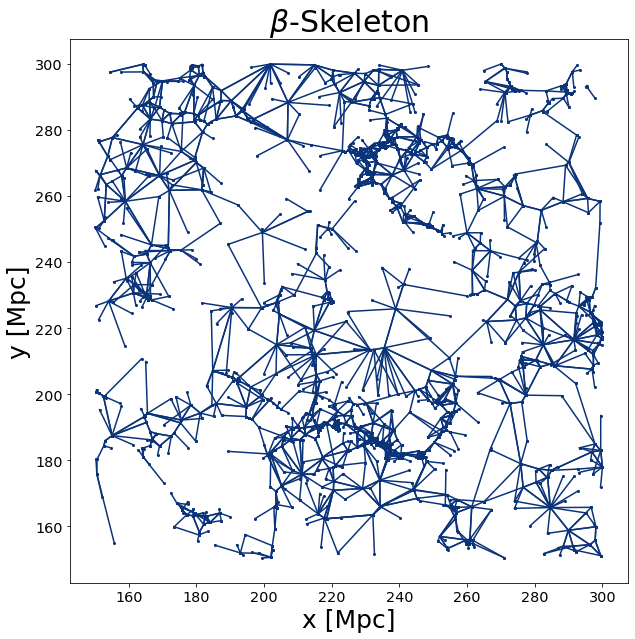

In [4]:
zin = 3
zlim = (max(z) - min(z))/2 + min(z)# Plane in z axis to plot the Bskeleton
maskzm = z < (zlim + zin)
maskzM = z > (zlim - zin)
IDzm = ID[maskzm & maskzM]

fig = plt.figure(figsize = (10,10))
plt.title(r'$\beta$-Skeleton',size=30)
plt.xlabel("x [Mpc]",size=25)
plt.ylabel("y [Mpc]",size=25)
for k in IDzm:
    for j in con[k]:
        plt.plot([x[k],x[j]],[y[k],y[j]],'o-',markersize=2, c="#0a337a")
plt.savefig('./figures/bsk.png', bbox_inches='tight', transparent=True)
plt.show()